# Kitaev Honeycomb Model with Vortices
    This notebook explores the eigenvalues of the Kitaev honeycomb model. 
    The following steps are carried out:
    1. Calculation of eigenvalues for the original model.
    2. Addition of two vortices and study of their impact.
    3. Examination of the energy splitting in the lowest energy states as vortices are brought closer.

    ## Key Steps:
    - **Theory**: The Kitaev model is an exactly solvable model on a two-dimensional honeycomb lattice, with significant relevance in quantum computation and topological phases of matter.
    - **Analysis**: The energy splitting as vortices are brought closer provides insights into the interaction between localized Majorana modes.

    Below, the workflow includes defining the Hamiltonian, computing eigenvalues, introducing vortices, 
    and analyzing results.

In [1]:
import numpy as np
from scipy import linalg
from scipy import sparse
import scipy.sparse.linalg
import time
import os
import matplotlib.pyplot as plt
import cmath 
import math
from scipy import optimize
from scipy.optimize import fmin
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

k[j,m] means the hopping is from site 'j' to site 'm'. It means, this hamiltonian is negative of the hamiltonian from the paper (Annals of Physics 321 (2006) 2--111). If you want your hamiltonian be the same from the paper, define your hopping parameter with a negative sign (J --> -J)

### Vortex free Kitaev's honeycomb model

In [6]:
#Kitaev honeycomb vortexfree
#gap found = 6*sqrt(3)
# defining the grid/ size of the hamiltonian will be nx*ny*nz
nx = 60
ny = 60
nz=2 #0=even, 1=odd

# Initializing the hamiltonians
kin = np.zeros((nx*ny*nz, nx*ny*nz), dtype=complex) # the kinetic energy
site = np.zeros((nx, ny, nz))
ste=[]
ax=[]
ay=[]

# the lattice vectors
a2 = np.array([-1/2, (np.sqrt(3)/2)])
a1 = np.array([1/2, (np.sqrt(3)/2)])

# the nearest neighbout (J) and next-nearest neighbour (K) vectors
J = (1)*1*1j # this is actually (i)*(2J) = J*(2)i
Jz = (1)*1*1j # this is actually (i)*(2J) = J*(2)i
K = (1)*0.05*1j

# the loop below assigns an unique index to each lattice points
i=-1
for x in range(0,nx):
    for y in range(0,ny):
        for z in range(0,nz):
            i=i+1
            site[x,y,z]=i
            #for plotting the lattice
            a = x*a1 + y*a2 + z*((a2 + a1)/3)
            ax.append(a[0])
            ay.append(a[1])
            ste.append(int(site[x,y,z]))

# construction of the hamiltonian
for x in range(0,nx):
    for y in range(0,ny):
        i = int(site[x,y,0])
        j = int(site[x,y,1])
        # in cell 0-1
        kin[i,j] = Jz
        kin[j,i] = -Jz
        # out-cell 1-0 (right)
        x1 = x + 1
        if x1 > nx-1:
            x1 = 0
        m = int(site[x1,y,0])
        kin[j,m] = -J
        kin[m,j] = J
        #NNN
        #0-0
        kin[i,m] = -K
        kin[m,i] = K
        #1-1
        m = int(site[x1,y,1])
        kin[j,m] = K
        kin[m,j] = -K
        # out-cell 0-1 (left)
        x1 = x - 1
        if x1 < 0:
            x1 = nx-1
        m = int(site[x1,y,1])
        kin[i,m] = J
        kin[m,i] = -J
        #NNN
        #0-0
        kin[j,m] = -K
        kin[m,j] = K
        #1-1
        m = int(site[x1,y,0])
        kin[i,m] = K
        kin[m,i] = -K
        #####
        # out-cell 1-0 (up)
        y1 = y + 1
        if y1 > ny-1:
            y1 = 0
        m = int(site[x,y1,0])
        kin[j,m] = -J
        kin[m,j] = J
        
        #Next Nearest Neighbour (NNN)
        #0-0
        kin[i,m] = K
        kin[m,i] = -K
        #1-1
        m = int(site[x,y1,1])
        kin[j,m] = -K
        kin[m,j] = K
        # out-cell 0-1 (down)
        y1 = y - 1
        if y1 < 0:
            y1 = ny-1
        m = int(site[x,y1,1])
        kin[i,m] = J
        kin[m,i] = -J
        #NNN
        #1-1
        kin[j,m] = K
        kin[m,j] = -K
        #0-0
        m = int(site[x,y1,0])
        kin[i,m] = -K
        kin[m,i] = K
        
        #NNN right and left
        #right 1 to 1
        x1 = x + 1
        if x1 > nx-1:
            x1 = 0
        y1 = y - 1
        if y1 < 0:
            y1 = ny-1
        m = int(site[x1,y1,1])
        kin[j,m] = -K
        kin[m,j] = K
        #left 1 to 1
        x1 = x - 1
        if x1 < 0:
            x1 = nx-1
        y1 = y + 1
        if y1 > ny-1:
            y1 = 0    
        m = int(site[x1,y1,1])
        kin[j,m] = K
        kin[m,j] = -K
        
        #right 0 to 0
        x1 = x + 1
        if x1 > nx-1:
            x1 = 0
        y1 = y - 1
        if y1 < 0:
            y1 = ny-1
        m = int(site[x1,y1,0])
        kin[i,m] = K
        kin[m,i] = -K
        #left 0 to 0
        x1 = x - 1
        if x1 < 0:
            x1 = nx-1
        y1 = y + 1
        if y1 > ny-1:
            y1 = 0    
        m = int(site[x1,y1,0])
        kin[i,m] = -K
        kin[m,i] = K

# since most of the elements are zeroes, we convert the matrix to a sparse matrix to increase the computational efficiency
sA = sparse.csr_matrix(kin)
    
#aa1 = scipy.sparse.linalg.eigsh(sA, k=int(nx*ny/2), sigma=0, tol=1.e-10, which='SA', return_eigenvectors=True)
aa1 = scipy.sparse.linalg.eigsh(sA, k=6, sigma=0, tol=1.e-10)
#aa1 = np.linalg.eig(kin)

# eigenvalues
eigen_a1 = aa1[0]

# eigenvectors
eigenv_a1 = aa1[1]


In [7]:
np.sort(eigen_a1)

array([-0.27922049, -0.25980762, -0.25980762,  0.25980762,  0.25980762,
        0.27922049])

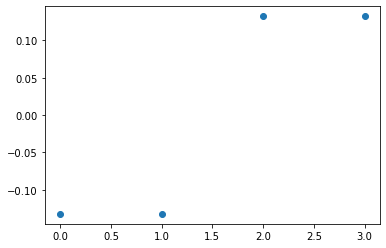

In [123]:
# plot the lowest energy eigenvalues
xa = np.arange(0,len(eigen_a1))
#eigen_as = eigen_a1.sort()
plt.scatter(xa, eigen_a1)

In [94]:
#checking if kin is hermitian or not
def check_symmetric(a, rtol=1e-05, atol=1e-08):
    return np.allclose(a, a.getH(), rtol=rtol, atol=atol)
check_symmetric(np.matrix(kin))

False

### Kitaev's Honeycomb model with two vortices

In [35]:
#Kitaev honeycomb with two vortices
#for variable distance b/w the vortices; to find the distance dependence of the splitting
nx = 60 #a multiple of 4 or change x1
ny = 60 #a multiple of 2 or change y1
nz=2 #0=even, 1=odd
kin = np.zeros((nx*ny*nz, nx*ny*nz), dtype=complex)
site = np.zeros((nx, ny, nz))

J = 1*1*1j # this is actually (i/4)*(2J) = J*(2/4)i
K = 0.05*1*1j
dist = []
eng=[]
st = 15 #start of the branch cut
ds = 25 #maximum distance between the vortices = dist+1, d runs from 1 to dist with an interval of 1

i=-1
for x in range(0,nx):
    for y in range(0,ny):
        for z in range(0,nz):
            i=i+1
            site[x,y,z]=i            

# We switch the links from +J -> -J and +K -> -K to create the vortices
for x in range(0,nx):
    for y in range(0,ny):
        i = int(site[x,y,0])
        j = int(site[x,y,1])
        # in cell 0-1
        kin[i,j] = J
        kin[j,i] = -J
        # out-cell 1-0 (right)
        x1 = x + 1
        if x1 > nx-1:
            x1 = 0
        m = int(site[x1,y,0])
        kin[j,m] = -J
        kin[m,j] = J
        #NNN
        #0-0
        kin[i,m] = -K
        kin[m,i] = K
        #1-1
        m = int(site[x1,y,1])
        kin[j,m] = K
        kin[m,j] = -K
        # out-cell 0-1 (left)
        x1 = x - 1
        if x1 < 0:
            x1 = nx-1
        m = int(site[x1,y,1])
        kin[i,m] = J
        kin[m,i] = -J
        #NNN
        #0-0
        kin[j,m] = -K
        kin[m,j] = K
        #1-1
        m = int(site[x1,y,0])
        kin[i,m] = K
        kin[m,i] = -K
        #####
        # out-cell 1-0 (up)
        y1 = y + 1
        if y1 > ny-1:
            y1 = 0
        m = int(site[x,y1,0])
        kin[j,m] = -J
        kin[m,j] = J
        #NNN
        #0-0
        kin[i,m] = K
        kin[m,i] = -K
        #1-1
        m = int(site[x,y1,1])
        kin[j,m] = -K
        kin[m,j] = K
        # out-cell 0-1 (down)
        y1 = y - 1
        if y1 < 0:
            y1 = ny-1
        m = int(site[x,y1,1])
        kin[i,m] = J
        kin[m,i] = -J
        #NNN
        #1-1
        kin[j,m] = K
        kin[m,j] = -K
        #0-0
        m = int(site[x,y1,0])
        kin[i,m] = -K
        kin[m,i] = K
        
        #NNN right and left
        #right 1 to 1
        x1 = x + 1
        if x1 > nx-1:
            x1 = 0
        y1 = y - 1
        if y1 < 0:
            y1 = ny-1
        m = int(site[x1,y1,1])
        kin[j,m] = -K
        kin[m,j] = K
        #left 1 to 1
        x1 = x - 1
        if x1 < 0:
            x1 = nx-1
        y1 = y + 1
        if y1 > ny-1:
            y1 = 0    
        m = int(site[x1,y1,1])
        kin[j,m] = K
        kin[m,j] = -K
        
        #right 0 to 0
        x1 = x + 1
        if x1 > nx-1:
            x1 = 0
        y1 = y - 1
        if y1 < 0:
            y1 = ny-1
        m = int(site[x1,y1,0])
        kin[i,m] = K
        kin[m,i] = -K
        #left 0 to 0
        x1 = x - 1
        if x1 < 0:
            x1 = nx-1
        y1 = y + 1
        if y1 > ny-1:
            y1 = 0    
        m = int(site[x1,y1,0])
        kin[i,m] = -K
        kin[m,i] = K

#placing the vortices
#remember 2J*uij, while 2K*uik*ujk (using Einstein sum conv) 
#st+d < nx
for d in range(1, ds):   
    y2 = int(ny/2)
    for x in range(st, st+d):
        i = int(site[x,y2,0])
        j = int(site[x,y2,1])
        # in cell 0-1
        kin[i,j] = -J
        kin[j,i] = J
        #add this if you want the K term in the vortex model
        x1 = x + 1
        if x1 > nx-1:
            x1 = 0
        m = int(site[x1,y2,0])
        #NNN
        #0-0
        kin[i,m] = K
        kin[m,i] = -K
        # out-cell left
        x1 = x - 1
        if x1 < 0:
            x1 = nx-1
        m = int(site[x1,y2,1])
        #NNN
        #1-1
        kin[j,m] = K
        kin[m,j] = -K
        #####
        # out-cell (up)
        y1 = y2 + 1
        m = int(site[x,y1,0])
        #NNN
        #0-0
        kin[i,m] = -K
        kin[m,i] = K
        # out-cell (down)
        y1 = y2 - 1
        m = int(site[x,y1,1])
        #NNN
        #1-1
        kin[j,m] = -K
        kin[m,j] = K
        #the very important step descending of y, it stays there regardless of the K term
        y2 = y2-1
    
    sA = sparse.csr_matrix(kin)
    #aa1 = scipy.sparse.linalg.eigsh(sA, k=2, sigma=0, tol=1.e-10)
    aa1 = scipy.sparse.linalg.eigsh(sA, k=1, sigma=0, tol=1.e-10, which = 'SA')    
    eigen_a1 = aa1[0]
    eigenv_a1 = aa1[1]
    dist.append(d)
    eng.append(eigen_a1)

#a2 = np.array([-1/2, (np.sqrt(3)/2)])
#a1 = np.array([1/2, (np.sqrt(3)/2)])

(0.0, 18.0)

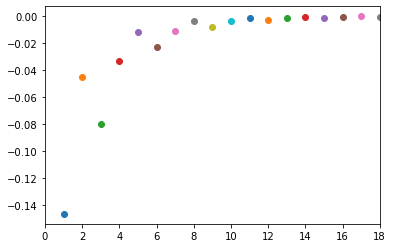

In [36]:
"""
This is a plot for the lowest energy state with distance between the vortices, as we move the vortices away from each other.
"""
for p,q in zip(dist, eng):
    plt.scatter([p]*len(q),q)
plt.xlim(0, 18) 
#plt.ylim(-0.05, 0.05) 

## We will visualize the lattice in the code below

In [3]:
#visualize the lattice
nx = 5
ny = 5
nz=2 #0=red, 1=greeen, 2=blue
kin = np.zeros((nx*ny*nz, nx*ny*nz))
gap = np.zeros((nx*ny*nz, nx*ny*nz))
kin1 = np.zeros((nx*ny*nz, nx*ny*nz))
gap1 = np.zeros((nx*ny*nz, nx*ny*nz))
site = np.zeros((nx, ny, nz))
imp = np.zeros((nx*ny*nz, nx*ny*nz))
mu = 1
t = 1.0
sc = 0.2
p = -0.5
J = 1*1j 
ax = []
ay = []

i=-1
for x in range(0,nx):
    for y in range(0,ny):
        for z in range(0,nz):
            i=i+1
            site[x,y,z]=i            

a2 = np.array([-1/2, (np.sqrt(3)/2)])
a1 = np.array([1/2, (np.sqrt(3)/2)])        
  
!rm kitaev.txt
    
for x in range(0,nx):
    for y in range(0,ny):
        for z in range(0,nz):
            a = x*a1 + y*a2 + z*((a2 + a1)/3)
            s1 = 0.0
            s2 = 0.0
            ax.append(a[0])
            ay.append(a[1])
            with open("kitaev.txt",'a+') as f:
                f.write(str(a[0])+"\t"+str(a[1])+"\t"+str(s1)+"\t"+str(s2)+"\n")        

NameError: name 'ste' is not defined

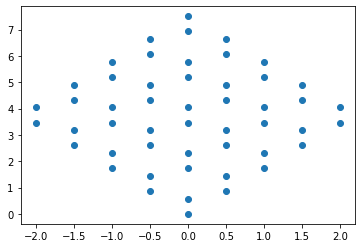

In [4]:
plt.scatter(ax, ay)
for i, txt in enumerate(ste):
    plt.annotate(txt, (ax[i], ay[i]))
plt.xlim(-5, 5) 
plt.ylim(0, 5)

In [9]:
#Kitaev honeycomb with two vortices
#for a fixed distance
#to see the two vortex wavefunction
nx = 60 #a multiple of 4 or change x1
ny = 60 #a multiple of 2 or change y1
nz=2 #0=even, 1=odd
kin = np.zeros((nx*ny*nz, nx*ny*nz), dtype=complex)
site = np.zeros((nx, ny, nz))

J = 1*1j # this is actually (i/4)*(2J) = J*(2/4)i
K = 0.05*1j
dist = []
eng=[]
st = 15 #start of the branch cut
d = 25
stop = st+d #end of the branch cut
#the distance between the vortices is (stop-st-1)

i=-1
for x in range(0,nx):
    for y in range(0,ny):
        for z in range(0,nz):
            i=i+1
            site[x,y,z]=i            

for x in range(0,nx):
    for y in range(0,ny):
        i = int(site[x,y,0])
        j = int(site[x,y,1])
        # in cell 0-1
        kin[i,j] = J
        kin[j,i] = -J
        # out-cell 1-0 (right)
        x1 = x + 1
        if x1 > nx-1:
            x1 = 0
        m = int(site[x1,y,0])
        kin[j,m] = -J
        kin[m,j] = J
        #NNN
        #0-0
        kin[i,m] = -K
        kin[m,i] = K
        #1-1
        m = int(site[x1,y,1])
        kin[j,m] = K
        kin[m,j] = -K
        # out-cell 0-1 (left)
        x1 = x - 1
        if x1 < 0:
            x1 = nx-1
        m = int(site[x1,y,1])
        kin[i,m] = J
        kin[m,i] = -J
        #NNN
        #1-1
        kin[j,m] = -K
        kin[m,j] = K
        #0-0
        m = int(site[x1,y,0])
        kin[i,m] = K
        kin[m,i] = -K
        #####
        # out-cell 1-0 (up)
        y1 = y + 1
        if y1 > ny-1:
            y1 = 0
        m = int(site[x,y1,0])
        kin[j,m] = -J
        kin[m,j] = J
        #NNN
        #0-0
        kin[i,m] = K
        kin[m,i] = -K
        #1-1
        m = int(site[x,y1,1])
        kin[j,m] = -K
        kin[m,j] = K
        # out-cell 0-1 (down)
        y1 = y - 1
        if y1 < 0:
            y1 = ny-1
        m = int(site[x,y1,1])
        kin[i,m] = J
        kin[m,i] = -J
        #NNN
        #1-1
        kin[j,m] = K
        kin[m,j] = -K
        #0-0
        m = int(site[x,y1,0])
        kin[i,m] = -K
        kin[m,i] = K
        
        #NNN right and left
        #right 1 to 1
        x1 = x + 1
        if x1 > nx-1:
            x1 = 0
        y1 = y - 1
        if y1 < 0:
            y1 = ny-1
        m = int(site[x1,y1,1])
        kin[j,m] = -K
        kin[m,j] = K
        #left 1 to 1
        x1 = x - 1
        if x1 < 0:
            x1 = nx-1
        y1 = y + 1
        if y1 > ny-1:
            y1 = 0    
        m = int(site[x1,y1,1])
        kin[j,m] = K
        kin[m,j] = -K
        
        #right 0 to 0
        x1 = x + 1
        if x1 > nx-1:
            x1 = 0
        y1 = y - 1
        if y1 < 0:
            y1 = ny-1
        m = int(site[x1,y1,0])
        kin[i,m] = K
        kin[m,i] = -K
        #left 0 to 0
        x1 = x - 1
        if x1 < 0:
            x1 = nx-1
        y1 = y + 1
        if y1 > ny-1:
            y1 = 0    
        m = int(site[x1,y1,0])
        kin[i,m] = -K
        kin[m,i] = K

#placing the vortices
#remember 2J*uij, while 2K*uik*ujk (using Einstein sum conv) 
#st+d < nx

y2 = int(ny/2)
for x in range(st, stop):
    i = int(site[x,y2,0])
    j = int(site[x,y2,1])
    # in cell 0-1
    kin[i,j] = -J
    kin[j,i] = J
    #add this if you want the K term in the vortex model
    x1 = x + 1
    if x1 > nx-1:
        x1 = 0
    m = int(site[x1,y2,0])
    #NNN
    #0-0
    kin[i,m] = K
    kin[m,i] = -K
    # out-cell left
    x1 = x - 1
    if x1 < 0:
        x1 = nx-1
    m = int(site[x1,y2,1])
    #NNN
    #1-1
    kin[j,m] = K
    kin[m,j] = -K
    #####
    # out-cell (up)
    y1 = y2 + 1
    m = int(site[x,y1,0])
    #NNN
    #0-0
    kin[i,m] = -K
    kin[m,i] = K
    # out-cell (down)
    y1 = y2 - 1
    m = int(site[x,y1,1])
    #NNN
    #1-1
    kin[j,m] = -K
    kin[m,j] = K
    #the very important step descending of y, it stays there regardless of the K term
    y2 = y2-1

    
sA = sparse.csr_matrix(kin)
aa1 = scipy.sparse.linalg.eigsh(sA, k=2, sigma=0, tol=1.e-10)
#aa1 = np.linalg.eig(kin)
eigen_a1 = aa1[0]
eigenv_a1 = aa1[1]
eng.append(eigen_a1)

a2 = np.array([-1/2, (np.sqrt(3)/2)])
a1 = np.array([1/2, (np.sqrt(3)/2)])

xd = []
xlt = []
xlte=[]
evd = []
evr=[]
y2 = int(ny/2)+5
for x in range(st-5,stop+5):
    evd.append(abs(eigenv_a1[int(site[x,y2,1])][0]))
    evr.append((eigenv_a1[int(site[x,y2,1])][0]+np.conj(eigenv_a1[int(site[x,y2,1])][0]))/np.sqrt(2))
    xd.append(x)
    xlt.append(x-(st)+0.5)
    #xlte.append(np.sqrt((x-(st)+0.5)**2+(1/(2*np.sqrt(3)))**2))
    a = x*a1 + y*a2 + z*((a2 + a1)/3)
    y2 = y2-1

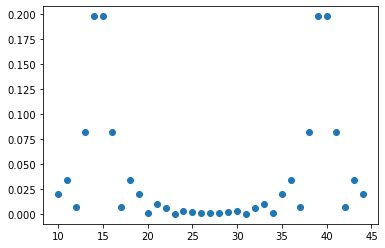

In [10]:
"""
This is a plot for the absolute value of the eigenvector at each lattice positions. The peaks at the position of the vortices shows that
the eigenvectors are locatized at the positon of the vortices.
"""
plt.scatter(xd, evd)
#plt.xlim(0,5)

In [11]:
"""
We extract the eigenvectors for the MZMs (Majorana Zero Modes) from the eigenvectors of the model
"""
#to plot the real and imaginary MZM
ev1 = []
ev2 = []
for i in range(0, len(eigenv_a1)):
    ev1.append(eigenv_a1[i][0])
evn=np.array(ev1)
np.sin(np.angle(evn))
def wf(t):
    w = sum((abs(evn)**2)*abs(np.sin(2*t+2*np.angle(evn))))
    return w
argwf = optimize.fmin(wf, 1.5)
evn1 = np.exp(argwf*1j)*evn
xd = []
evd = []
evr=[]
evl=[]
y2 = int(ny/2)+5
for x in range(st-5,stop+5):
    evl.append((evn1[int(site[x,y2,1])]+np.conj(evn1[int(site[x,y2,1])]))/np.sqrt(2))  #MZM on right
    evr.append((evn1[int(site[x,y2,1])]-np.conj(evn1[int(site[x,y2,1])]))/(np.sqrt(2)*1j))  #MZM on left
    xd.append(x)
    y2 = y2-1

Optimization terminated successfully.
         Current function value: 0.000915
         Iterations: 14
         Function evaluations: 28


In [12]:
#from H, we know that psi2=psi1*. so multiplying psi2 by e^(it) in a what that psi2=psi1*
evp = []
evn = []
evn1 = []
for i in range(0, len(eigenv_a1)):
    evp.append(eigenv_a1[i][0])
    evn1.append(eigenv_a1[i][1])
evpa=np.array(evp)
evn1a=np.array(evn1)
t=-np.log((np.dot(np.conj(evn1a),np.conj(evpa)))/(np.dot(np.conj(evn1a),evn1a))**2)*1j
evna = np.exp(t*1j)*evn1a

/home/Freewheelin/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


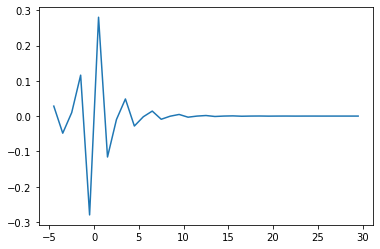

In [13]:
"""
Plot of the eigenvector locatized at the left vortex
"""
plt.plot(xlt, np.around(evl,6))
#plt.xlim(30,40)

/home/Freewheelin/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


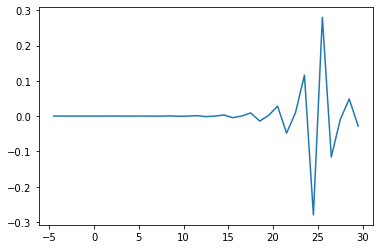

In [14]:
"""
Plot of the eigenvector locatized at the right vortex
"""
plt.plot(xlt, np.around(evr,6))

In [8]:
#wavefunction from the paper by Otten
J=1
K=0.05
ep = (6*K)/(J)
def wfm(x):
    #phi = np.arctan((1/(2*np.sqrt(3)))/x)
    phi = np.angle(x + (1/(2*np.sqrt(3)))*1j)
    return np.sqrt(ep/((np.pi)*(np.sqrt(x**2+(1/(2*np.sqrt(3)))**2))))*np.exp(-ep*(np.sqrt((x**2+(1/(2*np.sqrt(3)))**2))))*np.cos(-(2*np.pi*x/3)+(np.pi/4)+(phi/2))

In [59]:
cmath.phase(1 + (1/(2*np.sqrt(3)))*1j)

0.2810349015028136

In [65]:
np.arctan((1/(2*np.sqrt(3)))/2)

0.14334756890536537

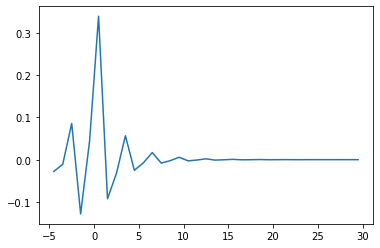

In [51]:
xdn = np.arange(-5,30,0.5)
#plt.plot(np.array(xlt),wfm(np.array(xlt)))
plt.plot(np.array(xlt),wfm(np.array(xlt)))
#plt.xlim(-5,5)

/home/Freewheelin/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:171: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


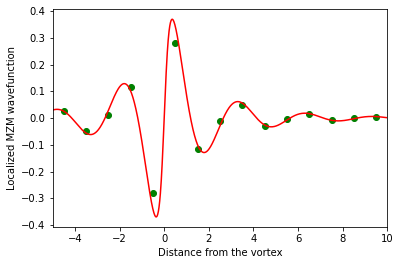

In [15]:
"""
Compare the eigenvector obtained from our effective model (red curve) with the numerical value (green dots)
"""
#compare mine with Oten's
#there is no reason to take the phase pi/4. I took pi/2 for better match
xlt1=np.arange(-5,20,0.01)
plt.plot(xlt1,wfm(xlt1), color='r')
#plt.plot(np.array(xlt),-wfm(np.array(xlt)), color='r')
plt.scatter(np.array(xlt), np.around((np.array(evl)),6), color='g')
plt.xlim(-5,10)
plt.xlabel('Distance from the vortex')
plt.ylabel('Localized MZM wavefunction')
plt.savefig('MZM.pdf')

# The below codes are for some experimentations with the phase of the wave function

/home/Freewheelin/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:171: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


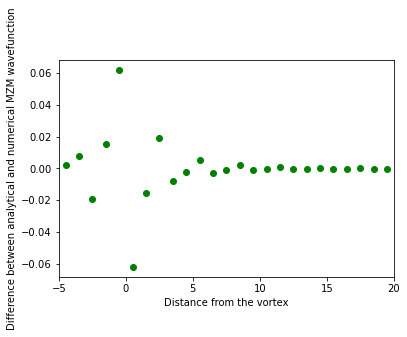

In [34]:
#compare mine with Oten's
#there is no reason to take the phase pi/4. I took pi/2 for better match
#xlt1=np.arange(-5,20,0.01)
#plt.plot(xlt1,wfm(xlt1), color='r')
#plt.scatter(np.array(xlt),wfm(np.array(xlt)), color='r')
plt.scatter(np.array(xlt), (np.around((np.array(evl)),6)-wfm(np.array(xlt))), color='g')
plt.xlim(-5,20)
plt.xlabel('Distance from the vortex')
plt.ylabel('Difference between analytical and numerical MZM wavefunction')
plt.savefig('MZM.pdf')

In [29]:
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
J=1
K=0.05
ep = (6*K)/(J)
xlt11 = np.array([ i for i in xlt1 if abs(i) > 0.1])
def wfm(x,a,b,c):
    phi = -0*(np.pi)-c*np.arctan((1/(2*np.sqrt(3)))/x)
    return a*np.sqrt(ep/((np.pi)*(np.sqrt(x**2+(1/(2*np.sqrt(3)))**2))))*np.exp(-ep*(np.sqrt((x**2+(1/(2*np.sqrt(3)))**2))))*np.cos(-(2*np.pi*x/3)+b+(np.pi/4)-phi/2)
popt, pcov = curve_fit(wfm, xlt, np.around((np.array(np.real(evl))),6), maxfev=1000)

popt

array([ 1.14454985,  0.78321822, -5.09773773])

(-0.5, 0.5)

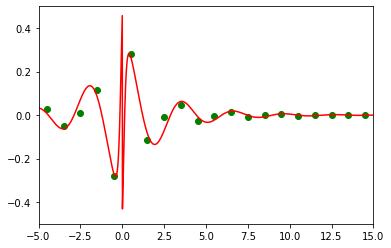

In [30]:
plt.scatter(np.array(xlt), np.around((np.array(np.real(evl))),6), color='g')
plt.plot(xlt1, wfm(xlt1, *popt), 'r-',
         label='fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt))
#plt.plot(np.array(xlt1),wfm(np.array(xlt1)),color='r')
plt.xlim(-5,15)
plt.ylim(-0.5,0.5)

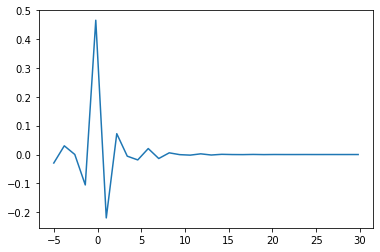

In [455]:
xdn = np.arange(-5,30,1.2)
#plt.plot(np.array(xlt),wfm(np.array(xlt)))
plt.plot(xdn,wfm(xdn))
#plt.xlim(-5,5)

In [467]:
wfm(-0.05)

0.5227843329589921

In [ ]:
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
J=1
K=0.05
ep = (6*K)/(J)
xlt11 = np.array([ i for i in xlt1 if abs(i) > 0.1])
def wfm(x,a,b,c):
    phi = np.arctan((c/(2*np.sqrt(3)))/x)
    return a*np.sqrt(ep/((np.pi)*(np.sqrt(x**2+(1/(2*np.sqrt(3)))**2))))*np.exp(-ep*(np.sqrt((x**2+(1/(2*np.sqrt(3)))**2))))*np.cos(-(2*np.pi*x/3)+b+phi/2)
popt, pcov = curve_fit(wfm, xlt, np.around((np.array(evr)),6), maxfev=1000)

popt

(0.0, 13.0)

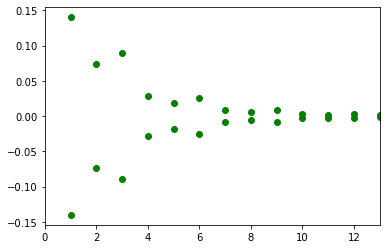

In [216]:
v = np.sqrt(3)*J/4
def spl(dn):
    return 4*v*abs(np.cos((2*np.pi*dn/3)))*np.sqrt(ep/(2*np.pi*dn))*np.exp(-ep*dn)
plt.scatter(np.array(dist),spl(np.array(dist)),color='g')
plt.scatter(np.array(dist),-spl(np.array(dist)),color='g')
plt.xlim(0, 13)

(0.0, 13.0)

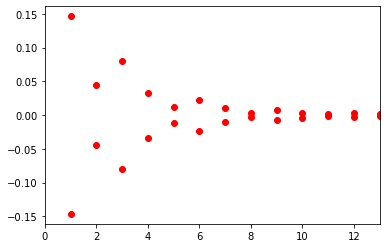

In [206]:
for p,q in zip(dist, eng):
    plt.scatter([p]*len(q),q, color='r')
plt.xlim(0, 13) 
#plt.ylim(-0.05, 0.05) 

(0.0, 13.0)

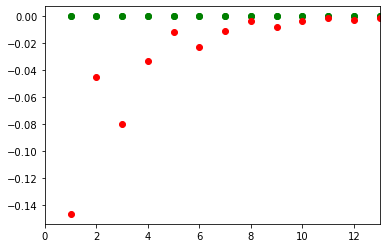

In [70]:
#compare the splitting
#green:effective, red:numeric
#90/ k = 0.03
v = np.sqrt(3)*J/4
def spl(dn):
    return 4*v*abs(np.cos((2*np.pi*dn/3)))*np.sqrt(ep/(2*np.pi*dn))*np.exp(-ep*dn)
plt.scatter(np.array(dist),spl(np.array(dist)),color='g')
plt.scatter(np.array(dist),-spl(np.array(dist)),color='g')
for p,q in zip(dist, eng):
    plt.scatter([p]*len(q),q, color='r')
plt.xlim(0, 13)

In [37]:
#compare the splitting
#green:effective, red:numeric
J = 1
K = 0.05
dl = np.arange(1,len(dist),0.01)
eng1 = []
ep = (6*K)/(J)
v = np.sqrt(3)*J/4
for i in range(0, len(eng)):
    eng1.append(eng[0][0])
eng1a = np.array(eng1)    
def spl(dn):
    return -4*v*abs(np.cos((2*np.pi*dn/(3))))*np.sqrt(ep/(2*np.pi*dn))*np.exp(-ep*dn)
#plt.scatter(np.array(dist),spl(np.array(dist)),color='g')
#plt.scatter(np.array(dist),-spl(np.array(dist)),color='g')
#plt.plot(dl,spl(dl),color='g')
#plt.plot(dl,-spl(dl),color='g')
#popt, pcov = curve_fit(spl, np.array(dist), eng1a, maxfev=1000)

#popt

(0.0, 13.0)

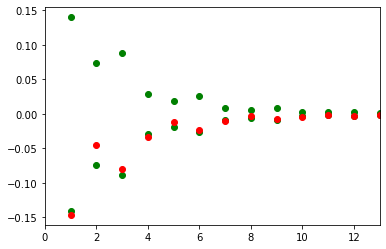

In [38]:
#compare the splitting
#green:effective, red:numeric
#90, K = 0.03
v = np.sqrt(3)*J/4
def spl(dn):
    return 4*v*abs(np.cos((2*np.pi*dn/3)))*np.sqrt(ep/(2*np.pi*dn))*np.exp(-ep*dn)
plt.scatter(np.array(dist),spl(np.array(dist)),color='g')
plt.scatter(np.array(dist),-spl(np.array(dist)),color='g')
for p,q in zip(dist, eng):
    plt.scatter([p]*len(q),q, color='r')
plt.xlim(0, 13)

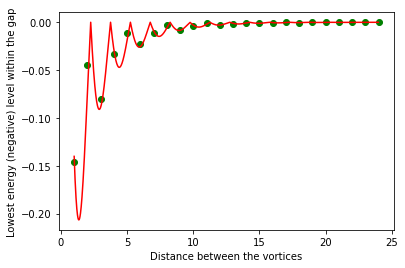

In [40]:
#expression for splitting
for p,q in zip(dist, eng):
    plt.scatter([p]*len(q),q, color='g')
plt.plot(dl, -spl(np.array(dl)),color='r')    
#plt.plot(dl, spl(np.array(dl), *popt), 'r-',
#         label='fit: a=%5.3f' % tuple(popt))    
#plt.xlim(1.9, 2.2)
#plt.ylim(-0.08, -0.01)
plt.xlabel('Distance between the vortices')
plt.ylabel('Lowest energy (negative) level within the gap')
plt.savefig('splitting.pdf')

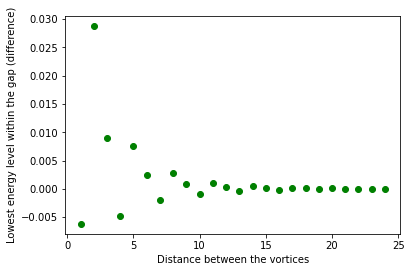

In [45]:
#expression for splitting
for p,q in zip(dist, eng):
    plt.scatter([p]*len(q),q-(-spl(p)), color='g')
#plt.scatter(dist, -spl(np.array(dist)),color='r')   
#plt.plot(dl, spl(np.array(dl), *popt), 'r-',
#         label='fit: a=%5.3f' % tuple(popt))
#plt.xlim(1.9, 2.2)
#plt.ylim(-0.08, -0.01)
plt.xlabel('Distance between the vortices')
plt.ylabel('Lowest energy level within the gap (difference)')
plt.savefig('splitting.pdf')

In [42]:
eng[1]

array([-0.04467596])

In [46]:
dl[100]
spl(dl[100])

-0.07343610563854565

(0.0, 15.0)

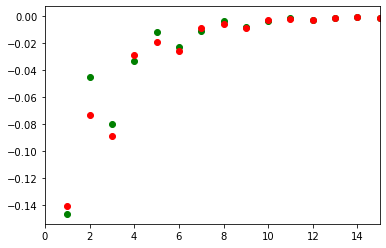

In [292]:
for p,q in zip(dist, eng):
    plt.scatter([p]*len(q),q, color='g')
plt.scatter(dist, spl(np.array(dist)),color='r')    
#plt.plot(dl, spl(np.array(dl), *popt), 'r-',
#         label='fit: a=%5.3f' % tuple(popt))    
plt.xlim(0, 15)
#plt.ylim(-0.1, 0.0)

In [76]:
ne = []
evre = []
for i in range(0, int(len(xlt)/2)+3):
    ne.append(xlt[i])
    evre.append(evr[i])
xlte=np.arange(-4.5,int(len(xlt)/2)+3,0.01)    

/home/Freewheelin/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:171: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


(-5.0, 7.0)

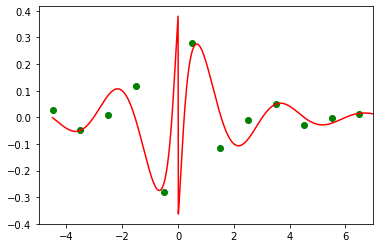

In [82]:
plt.scatter(np.array(ne), np.around((np.array(evre)),6), color='g')
plt.plot(xlte, wfm(xlte, *popt), 'r-',
         label='fit: a=%5.3f, b=%5.3f' % tuple(popt))
plt.xlim(-5,7)

In [283]:
spl(dl[106])

-0.055079868622893685

In [278]:
spl(dist[1])

-0.0734361056385459

In [517]:
#demo
#to plot the real and imaginary MZM
ev1 = []
ev2 = []
for i in range(0, len(eigenv_a1)):
    ev1.append(eigenv_a1[i][0])
evn=np.array(ev1)
np.sin(np.angle(evn))
def wf(t):
    w = sum((abs(evn)**2)*abs(np.sin(2*t+2*np.angle(evn))))
    return w
argwf = optimize.fmin(wf, 1.5)
evn1 = np.exp(argwf*1j)*evn
xd = []
evd = []
evr=[]
evl=[]
y2 = int(ny/2)+5
for x in range(st-5,stop+5):
    evr.append((evn1[int(site[x,y2,1])]+np.conj(evn1[int(site[x,y2,1])]))/np.sqrt(2))  #MZM on right
    evl.append((evn1[int(site[x,y2,1])]-np.conj(evn1[int(site[x,y2,1])]))/(np.sqrt(2)*1j))  #MZM on left
    xd.append(x)
    y2 = y2-1

Optimization terminated successfully.
         Current function value: 0.000913
         Iterations: 13
         Function evaluations: 26
